In [5]:
import random 
import math
import matplotlib.pyplot as plt
import numpy as np

class Deck:
    def __init__(self):
        self.cards = [Card(s, v) for s in ["Spades" , "Clubs" , "Hearts ", 
        "Diamonds"] for v in ["A" ,"2" ,"3" ,"4" ,"5" ,"6" 
        ,"7" ,"8" ,"9" ,"10" , "J" , "Q" , "K"] ]
        
    def shuffle(self):
        if len(self.cards) > 1:
            random.shuffle(self.cards)
    
    def deal(self):
        if len(self.cards) > 1:
            return self.cards.pop(0)
    

class Card: 
    def __init__(self, suit , value): 
        self.suit = suit 
        self.value = value 
    
    def __repr__(self):
        return " of " .join((self.value , self.suit))
    
class Hand:
    def __init__(self , dealer = False):
        self.dealer = dealer 
        self.cards = []
        self.value = 0 
        self.has_ace = False

    def new_card(self, card):
        self.cards.append(card)

    def calculate_card_values(self):
        self.value = 0 
        self.has_ace = False
        for card in self.cards:
            if card.value.isnumeric():
                self.value += int(card.value)
            else:
                if card.value == "A":
                    self.has_ace = True
                    self.value += 11
                    if self.value > 21:
                        self.value -= 10 
                        self.has_ace = False
                else:
                    self.value += 10
        return self.value

    def show_cards(self, first_state):
        if self.dealer and first_state: 
            print("Hidden")
            print(self.cards[1])
        else:
            for card in self.cards: 
                print(card)
            print("Value:" , self.calculate_card_values())
    
    def return_dealer_card(self):
        card_val = self.cards[1].value
        if card_val.isnumeric():
            return card_val
        else:
            if card_val == "A":
                return 11
            else:
                return 10
            
class Agent:
    def __init__(self):
        pass
    
    def check(self, player_sum, dealer_card, player_has_ace):
        self.player_sum = player_sum
        self.dealer_card = dealer_card
        self.player_has_ace = player_has_ace
        
        if self.player_sum > 21 and self.player_has_ace == True:
            self.player_sum = player_sum - 10
            self.player_has_ace = False
        
        return self.player_sum, self.player_has_ace
        
        
class Game: 
    
    def __init__(self):
        self.reward = 0
        #creating agent for each enivornment
        self.agent = Agent() 
    
    def start_game(self, num_of_episodes, Q, exploring_starts, e_config = None):
        
        agent = self.agent
        
        game_ongoing = True
        first_state = True

        #print("Game Starting \n")
        
        self.deck = Deck()
        self.deck.shuffle()
        
        self.player_hand = Hand()
        self.dealer_hand = Hand(dealer=True)
        
        game_actions = []

        for i in range(2):
            card = self.deck.deal() 
            self.player_hand.new_card(card)
            card = self.deck.deal()
            self.dealer_hand.new_card(card)

        while game_ongoing == True: 
            
#             print("\nYour hand is:")
#             self.player_hand.show_cards(first_state)
#             print()
#             print("Dealer's hand is: ")
#             self.dealer_hand.show_cards(first_state)
            
            player_blackjack, dealer_blackjack = self.blackjack_check()

            if player_blackjack or dealer_blackjack:
                game_ongoing = False 
                outcome = self.blackjack_display_results(player_blackjack , dealer_blackjack)
                return outcome, game_actions
            
            
            player_hand_value = self.player_hand.calculate_card_values()
            dealer_hand_value = self.dealer_hand.calculate_card_values()
            
            
            #dealer card is only hidden before player plays first round
            if first_state == True:
                dealer_sum = self.dealer_hand.return_dealer_card()
            else:
                dealer_sum = dealer_hand_value
            
           
            player_hand_value, player_has_ace = agent.check(player_hand_value, dealer_sum, self.player_hand.has_ace)
            
            if player_hand_value < 12:
                choice = 1
            elif player_hand_value > 20:
                choice = 2
            else:
                #monte carlo
                if exploring_starts == True and first_state == True:
                    #random action (explore)
                    choice = random.randint(1,2) #either choose hit or stand

                else:
                    #action is selected randomly with probability 𝜖 and  greedily with probability 1 − 𝜖
                    
                    if exploring_starts == False and e_config == 2:
                        #for not exploring starts configuration 2 (epsilon = 𝑒^(−𝑘/1000) )
                        epsilon = pow(math.e, ((0-num_of_episodes)/1000))
                    elif exploring_starts == False and e_config == 3:
                        #for not exploring starts configuration 2 (epsilon = 𝑒^(−𝑘/10000) )
                        epsilon = pow(math.e, ((0-num_of_episodes)/10000))
                    else:
                        #for exploring starts or not exploring starts configuration 1 (epsilon = 1/k)
                        epsilon = 1/num_of_episodes
                    
                    random_num = random.random() #generating random number between 0 and 1
                    
                    #if random number < epsilon, random action will be chosen
                    if random_num < epsilon:
                        #random action (explore)
                        choice = random.randint(1,2) #either choose hit or stand
                    else:
                        #greedy
                        for k, v in Q.items():
                            if k == (player_hand_value, player_has_ace, dealer_hand_value):
                                #choosing the greatest q value
                                if v[1] > v[2]:
                                    #hit has greater q value
                                    choice = 1
                                elif v[1] < v[2]:
                                    #stand has greater q value
                                    choice = 2
                                else:
                                    #if both actions have equal value then choose random action
                                    choice = random.randint(1,2)
                
                #choice = reinforment_learning_algorithm(agent, self.player_hand, player_hand_value, self.dealer_hand.return_dealer_card(), self.player_hand.has_ace, self.deck.cards)
           
                #game actions only stored in Q table if between 12 and 20 
                game_actions.append([(player_hand_value, player_has_ace, dealer_hand_value), choice])
            
            if (choice == 1):
                #print("\nPlayer Hit")
                #player chose to hit
                self.player_hand.new_card(self.deck.deal())
                #self.player_hand.show_cards(first_state)
                player_hand_value = self.player_hand.calculate_card_values()
                if (player_hand_value > 21):
                    #print("\nPlayer has lost !")
                    game_ongoing = False
                    return -1, game_actions

            elif (choice == 2):
                #player chose to stand
                #print("\nPlayer Stand")
                
                first_state = False
                
                # Dealer Policy
                if dealer_hand_value < 17:
                    #print("\nDealer Hit")
                    self.dealer_hand.new_card(self.deck.deal())
                    #self.dealer_hand.show_cards(first_state)
                    dealer_hand_value = self.dealer_hand.calculate_card_values()
                    if (dealer_hand_value > 21):
                        #print("\nDealer has lost !")
                        game_ongoing = False
                        return 1, game_actions

#                 print("\nFinal Results:")
#                 print("Player's hand:" , player_hand_value)
#                 print("Dealer's hand:" , dealer_hand_value)
                
                if player_hand_value < 21 and dealer_hand_value < 21:
                    if (player_hand_value > dealer_hand_value):
                        #print("\nPlayer Wins!")
                        return 1, game_actions
                    elif (player_hand_value == dealer_hand_value):
                        #print("\nTie!")
                        return 0, game_actions
                    else: 
                        #print("\nDealer Wins!")
                        return -1, game_actions
                elif player_hand_value >= 21 and dealer_hand_value < 21:
                    #print("\nDealer Wins!")
                    return -1, game_actions
                elif dealer_hand_value >= 21 and player_hand_value < 21:
                    #print("\nPlayer Wins!")
                    return 1, game_actions
                else:
                    #print("\nTie!")
                    return 0, game_actions
            
                game_ongoing = False 
        
            first_state = False


    def blackjack_check(self):
        player = False 
        dealer = False
        
        if self.player_hand.calculate_card_values() == 21: 
            player = True
        if self.dealer_hand.calculate_card_values() == 21:
            dealer = True 

        return player, dealer 
    
    def blackjack_display_results(self , player_blackjack , dealer_blackjack):
        if player_blackjack and dealer_blackjack:
            #print("Both players have blackjack! Draw!")
            return 0

        elif player_blackjack: 
            #print("Player has blackjack! Player wins!")
            return 1
        
        elif dealer_blackjack:
            #print("Dealer has blackjack! Dealer wins!")
            return -1

def reinforment_learning_algorithm(agent, player_cards, player_sum, dealer_sum, player_has_ace, deck_cards):
    has_ace = player_has_ace
    agent.check(player_sum, dealer_sum, player_has_ace)
    
    hit_num = 0
    stand_num = 0
    hit_value = 0
    stand_value = 0

    if has_ace == player_has_ace:
        converted_ace = False
    else:
        converted_ace = True

    possible_outcomes = []

    if player_sum < 12:
        #Hit when sum is less than 12 
        hit_num = hit_num + 1
        choice = 1
    elif (player_sum == 21):
        stand_num = stand_num + 1
        # Stand if sum is equal to 21
        choice = 2
    elif(player_sum >= 12 and player_sum < 21):
        for possible_card in deck_cards:
            possible_cards = possible_card.value
            
            if '2' in possible_cards:
                possible_value = 2
            elif '3' in possible_cards:
                possible_value = 3
            elif '4' in possible_cards:
                possible_value = 4
            elif '5' in possible_cards:
                possible_value = 5
            elif '6' in possible_cards:
                possible_value = 6
            elif '7' in possible_cards:
                possible_value = 7
            elif '8' in possible_cards:
                possible_value = 8
            elif '9' in possible_cards:
                possible_value = 9
            elif '10' in possible_cards:
                possible_value = 10
            elif 'J' in possible_cards:
                possible_value = 10
            elif 'Q' in possible_cards:
                possible_value = 10
            elif 'K' in possible_cards:
                possible_value = 10
            elif 'A' in possible_cards:
                possible_value = 11

            player_total = player_sum + possible_value

            if player_total < 21:
                choice = 1 #to hit
                hit_num = hit_num + 1
                if hit_num == 1:
                    hit_value = player_total
                else:
                    hit_value = (hit_value + player_total)/2
            elif player_total >= 21 and possible_value == 11 and converted_ace == False and player_total-10 < 21:
                player_total = player_total - 10
                choice = 1 #to hit
                hit_num = hit_num + 1
                if hit_num == 1:
                    hit_value = player_total
                else:
                    hit_value = (hit_value + player_total)/2
            else:
                player_total = player_sum
                choice = 2 #to stand
                stand_num = stand_num + 1
                if stand_num == 1:
                    stand_value = player_total
                else:
                    stand_value = round((stand_value + player_total)/2)

            possible_outcomes.append([player_sum, possible_card, player_total, choice])

    print("Number of hits on action: ", hit_num)
    print("Number of stands on action: ", stand_num,"\n")
    print("Estimated hit value: ", round(hit_value),"\n")
    print("Estimated stand value: ", stand_value,"\n")
    #print(possible_outcomes, "\n")   

    if hit_num > stand_num:
        print("Hit")
        return 1 #to hit
    elif hit_num < stand_num:
        print("Stand")
        return 2 #to stand
    else:
        if hit_value > stand_value:
            print("Hit")
            return 1 # to hit
        else:
            print("Stand")
            return 2 #if equal then best option is to stand


### Config 1: Exploring States

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

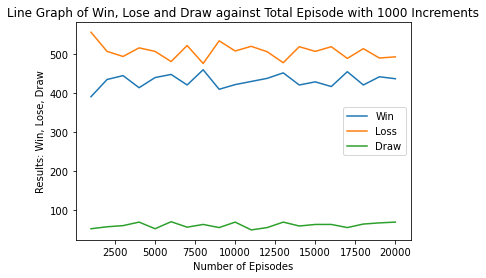

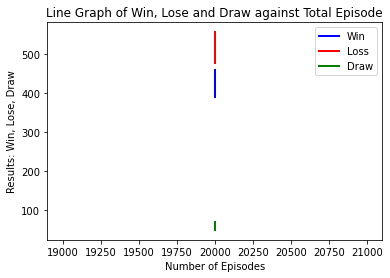

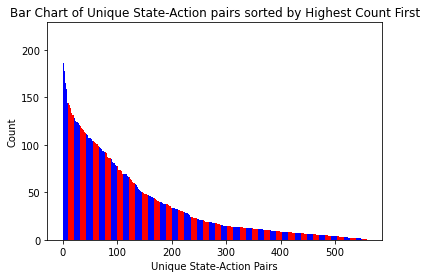


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'H'}, (13, 5): {0: 'H'}, (13, 6): {0: 'S'}, (13, 7): {0: 'H'}, (13, 8): {0: 'S'}, (13, 9): {0: 'H'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'H'}, (14, 5): {0: 'H'}, (14, 6): {0: 'H'}, (14, 7): {0: 'H'}, (14, 8): {0: 'H'}, (14, 9): {0: 'H'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'H'}, (15, 5): {0: 'S'}, (15, 6): {0: 'S'}, (15, 7): {0: 'H'}, (15, 8): {0: 'H'}, (15, 9): {0: 'H'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'S'}, (16, 5): {0: 'S'}, (16, 6): {0: 'S'}, (16, 7): {0: 'H'}, (16, 8): {0: 'H'}, (16, 9): {0: 'S'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'S'}, (17, 5): {0: 'S'}, (17, 6): {0: 

In [6]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 20000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = True, e_config = None)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
#     print("\nN: ",N)
#     print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique = num_unique + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique = num_unique + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
#     if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
#         for i in range(100): #to get the mean for last 100000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
    
#         mean_win = mean_win/100000
#         mean_loss = mean_loss/100000
#         mean_draw = mean_draw/100000
    
    if len(win) >= 20 and len(loss) >= 20 and len(draw) >= 20:
        for i in range(20): #to get the mean for last 2000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
        
        mean_win = mean_win/2000
        mean_loss = mean_loss/2000
        mean_draw = mean_draw/2000
    
    dealer_advantage_exploring = ((mean_loss-mean_win)/(mean_loss+mean_win))

### Config 2: No Exploring States epsilon=1/k

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

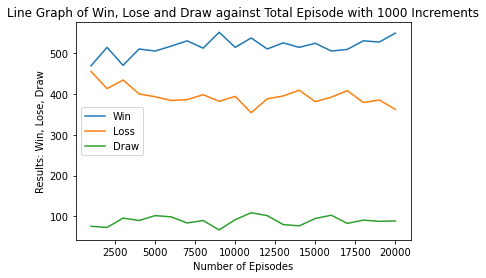

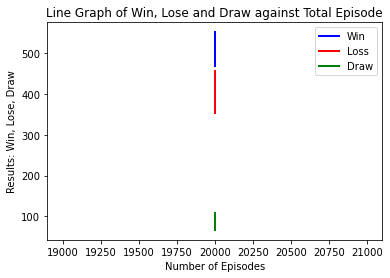

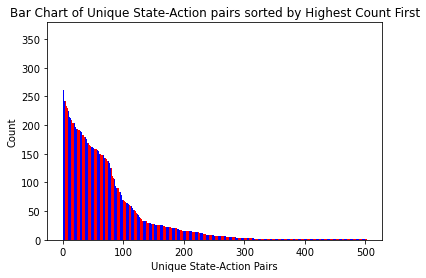


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'H'}, (13, 5): {0: 'S'}, (13, 6): {0: 'S'}, (13, 7): {0: 'H'}, (13, 8): {0: 'H'}, (13, 9): {0: 'S'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'H'}, (14, 5): {0: 'H'}, (14, 6): {0: 'S'}, (14, 7): {0: 'H'}, (14, 8): {0: 'S'}, (14, 9): {0: 'H'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'S'}, (15, 5): {0: 'S'}, (15, 6): {0: 'S'}, (15, 7): {0: 'S'}, (15, 8): {0: 'H'}, (15, 9): {0: 'S'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'H'}, (16, 5): {0: 'S'}, (16, 6): {0: 'S'}, (16, 7): {0: 'S'}, (16, 8): {0: 'S'}, (16, 9): {0: 'H'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'S'}, (17, 5): {0: 'S'}, (17, 6): {0: 

In [4]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 20000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique2 = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = False, e_config = 1)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
#     print("\nN: ",N)
#     print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique2 = num_unique2 + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique2 = num_unique2 + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique2)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
#     if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
#         for i in range(100): #to get the mean for last 100000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
    
#         mean_win = mean_win/100000
#         mean_loss = mean_loss/100000
#         mean_draw = mean_draw/100000
    
    if len(win) >= 20 and len(loss) >= 20 and len(draw)>= 20:
        for i in range(20): #to get the mean for last 20000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
        
        mean_win = mean_win/20000
        mean_loss = mean_loss/20000
        mean_draw = mean_draw/20000
    
    dealer_advantage_no_exploring_1 = ((mean_loss-mean_win)/(mean_loss+mean_win))
   

### Config 3: No Exploring States epsilon=e^(-k/1000)

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Finished

Number of unique state-action pairs, explored after running all episodes:  542


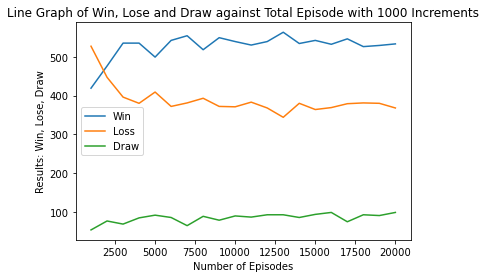

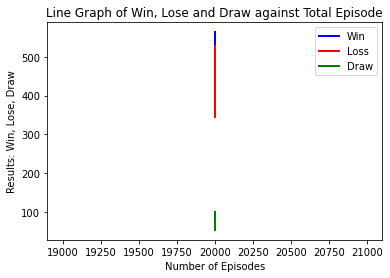

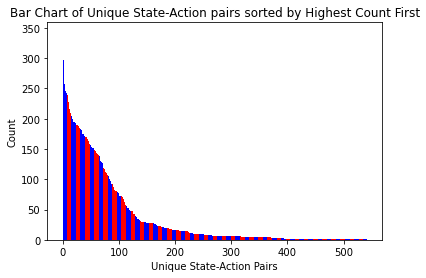


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'H'}, (13, 5): {0: 'H'}, (13, 6): {0: 'H'}, (13, 7): {0: 'H'}, (13, 8): {0: 'H'}, (13, 9): {0: 'H'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'S'}, (14, 5): {0: 'S'}, (14, 6): {0: 'H'}, (14, 7): {0: 'H'}, (14, 8): {0: 'H'}, (14, 9): {0: 'H'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'H'}, (15, 5): {0: 'S'}, (15, 6): {0: 'S'}, (15, 7): {0: 'S'}, (15, 8): {0: 'S'}, (15, 9): {0: 'S'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'S'}, (16, 5): {0: 'S'}, (16, 6): {0: 'S'}, (16, 7): {0: 'S'}, (16, 8): {0: 'S'}, (16, 9): {0: 'S'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'H'}, (17, 5): {0: 'S'}, (17, 6): {0: 

In [7]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 20000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique3 = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = False, e_config = 2)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
#     print("\nN: ",N)
#     print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique3 = num_unique3 + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique3 = num_unique3 + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique3)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
#     if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
#         for i in range(100): #to get the mean for last 100000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
    
#         mean_win = mean_win/100000
#         mean_loss = mean_loss/100000
#         mean_draw = mean_draw/100000
    
    if len(win) >= 20 and len(loss) >= 20 and len(draw)>= 20:
        for i in range(20): #to get the mean for last 20000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
        
        mean_win = mean_win/20000
        mean_loss = mean_loss/20000
        mean_draw = mean_draw/20000
    
    dealer_advantage_no_exploring_2 = ((mean_loss-mean_win)/(mean_loss+mean_win))

### Config 4: No Exploring States epsilon=e^(-k/10000)

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Finished

Number of unique state-action pairs, explored after running all episodes:  557


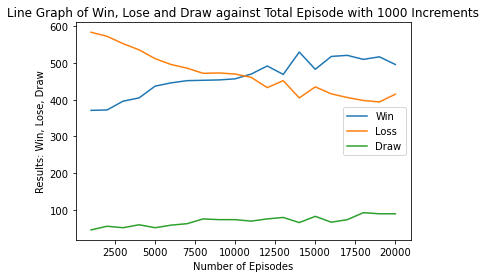

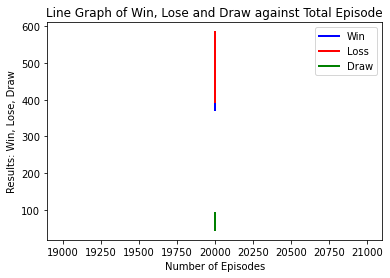

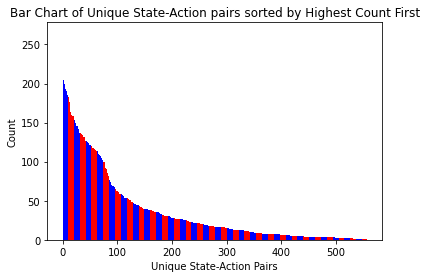


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'H'}, (13, 5): {0: 'H'}, (13, 6): {0: 'H'}, (13, 7): {0: 'H'}, (13, 8): {0: 'H'}, (13, 9): {0: 'S'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'S'}, (14, 5): {0: 'S'}, (14, 6): {0: 'H'}, (14, 7): {0: 'S'}, (14, 8): {0: 'H'}, (14, 9): {0: 'H'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'S'}, (15, 5): {0: 'H'}, (15, 6): {0: 'S'}, (15, 7): {0: 'H'}, (15, 8): {0: 'H'}, (15, 9): {0: 'H'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'S'}, (16, 5): {0: 'S'}, (16, 6): {0: 'S'}, (16, 7): {0: 'H'}, (16, 8): {0: 'S'}, (16, 9): {0: 'S'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'H'}, (17, 5): {0: 'S'}, (17, 6): {0: 

In [8]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 20000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique4 = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = False, e_config = 3)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
#     print("\nN: ",N)
#     print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique4 = num_unique4 + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique4 = num_unique4 + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique4)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
#     if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
#         for i in range(100): #to get the mean for last 100000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
    
#         mean_win = mean_win/100000
#         mean_loss = mean_loss/100000
#         mean_draw = mean_draw/100000
    
    if len(win) >= 20 and len(loss) >= 20 and len(draw)>= 20:
        for i in range(20): #to get the mean for last 20000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
        
        mean_win = mean_win/20000
        mean_loss = mean_loss/20000
        mean_draw = mean_draw/20000
    

    dealer_advantage_no_exploring_3 = ((mean_loss-mean_win)/(mean_loss+mean_win))

### Plots 

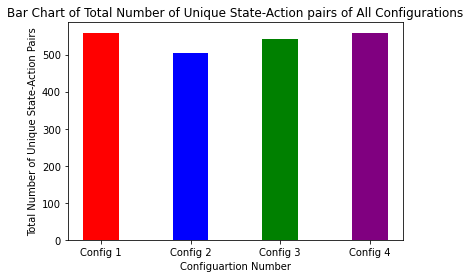

In [9]:
#plot 3
#put the total unique counts and config names in a list
t_unique = []
names = []

names.append('Config 1')
names.append('Config 2')
names.append('Config 3')
names.append('Config 4')

t_unique.append(num_unique)
t_unique.append(num_unique2)
t_unique.append(num_unique3)
t_unique.append(num_unique4)

t_list = list(zip(names,t_unique)) 

#plot 
labels, ys = zip(*t_list)
xs = np.arange(len(labels))


plt.bar(xs, ys, width = 0.4, align = 'center', color = ['red', 'blue', 'green', 'purple'])
plt.xticks(xs, labels) 
plt.yticks()
plt.xlabel('Configuartion Number')
plt.ylabel('Total Number of Unique State-Action Pairs')
plt.title('Bar Chart of Total Number of Unique State-Action pairs of All Configurations')
plt.show()

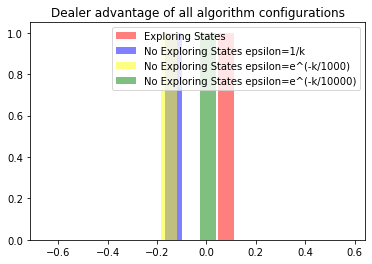

In [10]:
plt.hist(dealer_advantage_exploring, bins=15, alpha=0.5, color = 'red')
plt.hist(dealer_advantage_no_exploring_1, bins=15, alpha=0.5, color = 'blue')
plt.hist(dealer_advantage_no_exploring_2, bins=15, alpha=0.5, color = 'yellow')
plt.hist(dealer_advantage_no_exploring_3, bins=15, alpha=0.5, color = 'green')
plt.title("Dealer advantage of all algorithm configurations")
plt.legend(['Exploring States', 'No Exploring States epsilon=1/k', 'No Exploring States epsilon=e^(-k/1000)', 'No Exploring States epsilon=e^(-k/10000)'])
plt.show()